In [1]:
# ! pip install sympy

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm
from scipy.stats import norm


X = np.linspace(-3.6, 3.6, 300)
y = np.linspace(-3.6, 3.6, 300)

X, Y = np.meshgrid(X, y)

In [3]:
import matplotlib as mpl

new_rc_params = {'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
    }
mpl.rcParams.update(new_rc_params)
plt.rc('axes', axisbelow=True)

In [4]:
# Imagine a toy situation, where we wish to learn 2 weights that maximise a Z-score
# The underlying metrics have means/variances as follows:
mu_A = np.array([1.0, 1.0])
mu_B = np.array([0.5, 0.5])

sigma_A = np.eye(2)
sigma_B = np.eye(2)

In [5]:
import sympy as sp
import math

def gradient_multi(w, mu_As, mu_Bs):
    # Define symbols and the expression
    x1_sym, x2_sym = sp.symbols('x1 x2')
    
    expression = (x1_sym * mu_As[0][0] + x2_sym * mu_As[0][1] - (x1_sym * mu_Bs[0][0] + x2_sym * mu_Bs[0][1])) / sp.sqrt(2 * x1_sym**2 + 2 * x2_sym**2)

    for mu_A, mu_B in zip(mu_As[1:], mu_Bs[1:]):
        expression += (x1_sym * mu_A[0] + x2_sym * mu_A[1] - (x1_sym * mu_B[0] + x2_sym * mu_B[1])) / sp.sqrt(2 * x1_sym**2 + 2 * x2_sym**2)

    expression /= len(mu_As)
    
    # Calculate the partial derivatives
    df_dx1 = sp.diff(expression, x1_sym)
    df_dx2 = sp.diff(expression, x2_sym)

    # Substitute the given point (x1, x2) into the derivatives
    x1, x2 = w[0], w[1]
    
    gradient_x1 = df_dx1.subs({x1_sym: x1, x2_sym: x2})
    gradient_x2 = df_dx2.subs({x1_sym: x1, x2_sym: x2})

    return (gradient_x1, gradient_x2)

def gradient_multi_fixed_location(w, mu_As, mu_Bs):
    # Define symbols and the expression
    x1_sym, x2_sym = sp.symbols('x1 x2', real=True)
    
    expression = (x1_sym * mu_As[0][0] + x2_sym * mu_As[0][1] - (x1_sym * mu_Bs[0][0] + x2_sym * mu_Bs[0][1])) / sp.sqrt(2 * x1_sym**2 + 2 * x2_sym**2)

    for mu_A, mu_B in zip(mu_As[1:], mu_Bs[1:]):
        expression += (x1_sym * mu_A[0] + x2_sym * mu_A[1] - (x1_sym * mu_B[0] + x2_sym * mu_B[1])) / sp.sqrt(2 * x1_sym**2 + 2 * x2_sym**2)

    expression -= 0.005 * sp.Abs(4.0 - (x1_sym**2+x2_sym**2))     
    expression /= len(mu_As)
    
    # Calculate the partial derivatives
    df_dx1 = sp.diff(expression, x1_sym)
    df_dx2 = sp.diff(expression, x2_sym)

    # Substitute the given point (x1, x2) into the derivatives
    x1, x2 = w[0], w[1]
    
    gradient_x1 = df_dx1.subs({x1_sym: x1, x2_sym: x2})
    gradient_x2 = df_dx2.subs({x1_sym: x1, x2_sym: x2})

    return (gradient_x1, gradient_x2)

In [6]:
def Zscore(X,Y, mu_A, mu_B):
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            w = np.asarray([X[i,j], Y[i,j]])
            Z[i,j] = (w @ mu_A - w @ mu_B) / np.sqrt(w.T @ sigma_A @ w + w.T @ sigma_B@ w)
    return Z

def absolute_Zscore(X,Y, mu_A, mu_B):
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            w = np.asarray([X[i,j], Y[i,j]])
            Z[i,j] = np.abs((w @ mu_A - w @ mu_B) / np.sqrt(w.T @ sigma_A @ w + w.T @ sigma_B@ w))
    return Z

def Zscore_fixed_location(X,Y, mu_A, mu_B):
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            w = np.asarray([X[i,j], Y[i,j]])
            Z[i,j] = (w @ mu_A - w @ mu_B) / np.sqrt(w.T @ sigma_A @ w + w.T @ sigma_B@ w)
    return Z

In [7]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

def plot_loss_surface(mu_As, mu_Bs, Zscore, gradient_multi, filename):
    fig, axes = plt.subplots(1, 2, sharey=True,figsize=(8,4.5))
    
    fontsize=16

    # Z-scores
    Z = Zscore(X,Y, mu_As[0], mu_Bs[0])
    for mu_A, mu_B in zip(mu_As[1:], mu_Bs[1:]):
        Z += Zscore(X,Y, mu_A, mu_B)

    if Zscore == Zscore_fixed_location:
        Z -= 0.005 * np.abs(4.0 - (X**2+Y**2))
    Z /= len(mu_As)
    Z[np.isnan(Z)] = 0.0

    #clev = np.linspace(Z.min(), Z.max(), 21)
    clev = np.linspace(-.5, +.5, 21)
    for v in [.475, .495]:
        clev = np.insert(clev, clev.searchsorted(v), v)

    if Zscore != Zscore_fixed_location and Zscore != absolute_Zscore:
        for v in [-.475, -.495]:
            clev = np.insert(clev, clev.searchsorted(v), v)
    elif Zscore == Zscore_fixed_location:
        for v in [-.6,]: # -.7, -.8]:
            clev = np.insert(clev, clev.searchsorted(v), v)
   

    CS = axes[0].contour(X, Y, Z, clev, cmap=plt.cm.coolwarm)
    axes[0].clabel(CS, inline=True, fontsize=fontsize-4)
    axes[0].axis('scaled')
    axes[0].set_xlabel(r'$w_{1}$', fontsize=fontsize)
    axes[0].set_ylabel(r'$w_{2}$', fontsize=fontsize)

    for tick in axes[0].xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 
    for tick in axes[0].yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 
    
    opt_x, opt_y = [], []
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if (np.abs(Z - Z.max()) < 1e-8)[i,j]:
                opt_x.append(X[i,j])
                opt_y.append(Y[i,j])
    axes[0].plot(opt_x, opt_y, color='yellowgreen',lw=2, label=r'$w^{\star} (0.5)$')

    if len(opt_x) == 1:
        opt = axes[0].scatter(opt_x, opt_y, color='yellowgreen', marker='*', label=r'$w^{\star}$', s=125)
    
    eps=5e-3
    clev = np.arange(Z.min(),Z.max()+eps,eps)
    CS = axes[1].contourf(X, Y, Z, clev, cmap=plt.cm.coolwarm)
    cbar = plt.colorbar(CS, ax=axes, anchor=(2.2, 0.5), shrink=0.95, ticks=[-0.5, 0, 0.5])
    cbar.ax.tick_params(labelsize=fontsize-2)
    axes[1].set_xlabel(r'$w_{1}$', fontsize=fontsize)
    axes[1].set_ylabel(r'$w_{2}$', fontsize=fontsize)

    gx, gy = np.meshgrid(np.linspace(X.min(), X.max(), 21), np.linspace(Y.min(), Y.max(), 21))
    dx, dy = np.zeros_like(gx), np.zeros_like(gy)
    for i in range(gx.shape[0]):
        for j in range(gx.shape[0]):
            if np.abs(gx[i,j]) < 1e-8 and np.abs(gy[i,j]) < 1e-8:
                dx[i,j], dy[i,j] = 0.0, 0.0
            else:
                try:
                    dx_ij, dy_ij = gradient_multi(np.asarray([gx[i, j], gy[i, j]]), mu_As, mu_Bs)
                    dx[i,j] = float(dx_ij.evalf())
                    dy[i,j] = float(dy_ij.evalf())
                except:
                    print(np.asarray([gx[i, j], gy[i, j]]), mu_As, mu_Bs)
                    print(dx_ij)
                    print(dy_ij)
                    print(dx_ij.evalf())
                    print(dy_ij.evalf())
                    return

    norm = np.linalg.norm(np.array((dx, dy)), axis=0)
    norm[norm < 1e-10] = 0.0
    dx = dx / norm
    dy = dy / norm

    q = axes[1].quiver(gx, gy, dx, dy, units='xy', scale=3, color='gold', label=r'$\nabla z$')
    axes[1].axis('scaled')

    opt_x, opt_y = [], []
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if (np.abs(Z - Z.max()) < 1e-8)[i,j]:
                opt_x.append(X[i,j])
                opt_y.append(Y[i,j])
    opt, = axes[1].plot(opt_x, opt_y, color='yellowgreen', lw=2, label=r'$w^{\star}$')
    
    if len(opt_x) == 1:
        opt = axes[1].scatter(opt_x, opt_y, color='yellowgreen', marker='*', label=r'$w^{\star}$', s=125)
    
    for tick in axes[1].xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 
    for tick in axes[1].yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 

    def make_legend_arrow(legend, orig_handle,
                          xdescent, ydescent,
                          width, height, fontsize):
        p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
        return p

    axes[1].legend([mpatches.FancyArrow(0, 1, 1, 0, length_includes_head=True, head_width=0.75*1, color='gold'), opt],
               [r'$\nabla z$', r'$w^{\star}$'],
               handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow), },
               loc='lower right',
               fontsize=fontsize)

    fig.tight_layout()
    plt.savefig(filename, transparent=True, bbox_inches='tight')
    plt.show()

/var/tmp/ipykernel_8622/1875528015.py:83: RuntimeWarning: divide by zero encountered in divide
  dx = dx / norm
/var/tmp/ipykernel_8622/1875528015.py:83: RuntimeWarning: invalid value encountered in divide
  dx = dx / norm
/var/tmp/ipykernel_8622/1875528015.py:84: RuntimeWarning: divide by zero encountered in divide
  dy = dy / norm
/var/tmp/ipykernel_8622/1875528015.py:84: RuntimeWarning: invalid value encountered in divide
  dy = dy / norm
/var/tmp/ipykernel_8622/1875528015.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


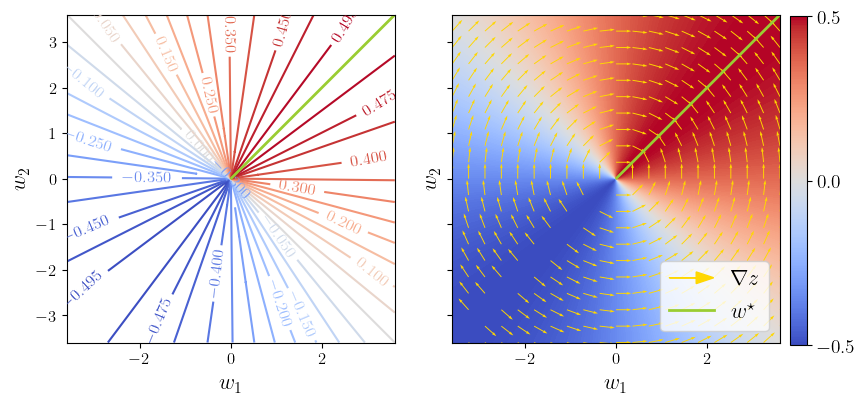

In [8]:
mu_As = [mu_A,]
mu_Bs = [mu_B,]

plot_loss_surface(mu_As, mu_Bs, Zscore, gradient_multi, 'Fig1_standard.pdf')

/var/tmp/ipykernel_8622/1875528015.py:83: RuntimeWarning: invalid value encountered in divide
  dx = dx / norm
/var/tmp/ipykernel_8622/1875528015.py:84: RuntimeWarning: invalid value encountered in divide
  dy = dy / norm
/var/tmp/ipykernel_8622/1875528015.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


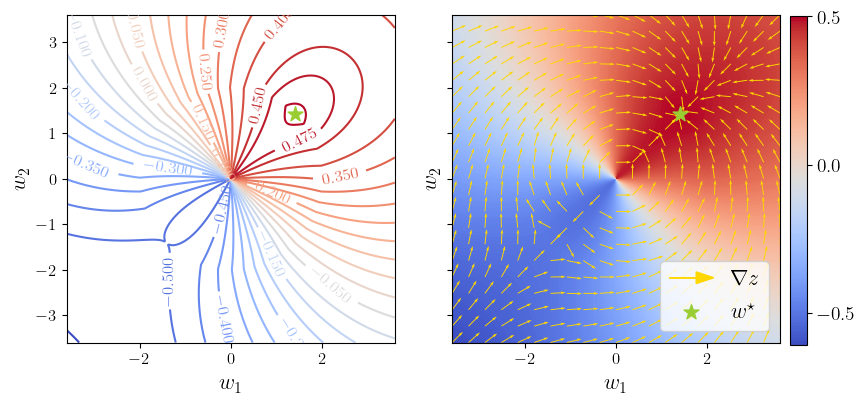

In [9]:
plot_loss_surface(mu_As, mu_Bs, Zscore_fixed_location, gradient_multi_fixed_location, 'Fig2_fixedloc.pdf')

In [10]:
import scipy.stats
from scipy.optimize import minimize

def objective_function(mu_A, mu_B, epsilon, *args):
    w = np.asarray(*args)
    
    zscore = (w @ mu_A - w @ mu_B) / np.sqrt(w.T @ sigma_A @ w + w.T @ sigma_B@ w)

    pvalue = 1.0 - scipy.stats.norm.cdf(zscore)
                                             
    return pvalue + epsilon * np.abs(2 - np.sum(np.asarray(*args)**2))
    
w_init = [1.0, -2.0]

In [11]:
opt = minimize(lambda coeffs: objective_function(mu_A, mu_B, 0.0, coeffs), x0=w_init, method='L-BFGS-B')
opt.x

array([13.09490446, 13.07465648])

In [12]:
opt = minimize(lambda coeffs: objective_function(mu_A, mu_B, 0.01, coeffs), x0=w_init, method='L-BFGS-B')
opt.x

array([0.99952688, 1.00047306])